# TODO:
1. Tune resnet feature extractor for 64x64 cifar10 images
1. Build custom image-preprocessing function to not rely on kerases one
1. Check what preprocessing has to be in place for opencv imread()

https://pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/

# Load train and test data

In [23]:
import numpy as np
from pathlib import Path
from sklearn.utils import Bunch
import cv2 as cv

def load_image_files(images_dir_path, test_size=0.2, target_size=(224, 224)):
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []
    test_data = []

    for class_index, directory in enumerate(directories):
        class_images_cnt = 0
        for file in directory.iterdir():
            class_images_cnt += 1

        test_size_cnt = int(class_images_cnt * test_size)
        for i, file in enumerate(directory.iterdir()):
            image = cv.imread(file.as_posix(), cv.IMREAD_COLOR)
            image = cv.resize(image, target_size)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image_data = cv.cvtColor(image, cv.COLOR_RGB2BGR)
            image_data = image_data - [103.939, 116.779, 123.68]

            batch = Bunch(
                image=image,
                image_data=image_data,
                class_index=class_index,
                class_name=classes[class_index],
            )

            if i < test_size_cnt:
                test_data.append(batch)
                continue

            train_data.append(batch)

    return train_data, test_data


train_dataset, test_dataset = load_image_files("groceries", target_size=(224, 224))
# train_dataset, test_dataset = load_image_files("cifar-10", target_size=(64, 64))

print("image-data shape:", np.shape(train_dataset[0].image_data))
print("image-data min:", min(map(lambda x: x.image_data.min(), train_dataset)))
print("image-data max:", max(map(lambda x: x.image_data.max(), test_dataset)))
print("train-dataset size:", len(train_dataset))
print("test-dataset size:", len(test_dataset))

TypeError: load_image_files() got an unexpected keyword argument 'dimension'

# Render sample train image

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random_index = np.random.randint(len(train_dataset))

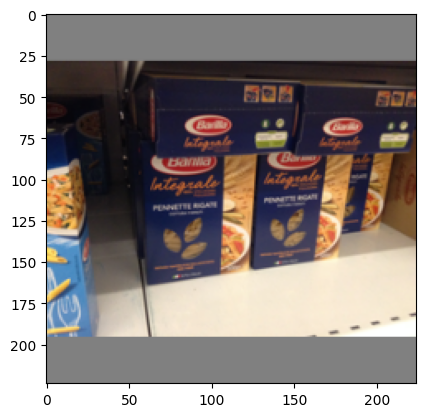

In [13]:
plt.imshow(train_dataset[random_index].image.astype(int))
plt.show()

# Extract train and test data from batches

In [14]:
import numpy as np

x_train = np.asarray(list(map(lambda batch: batch.image_data, train_dataset)))
x_test = np.asarray(list(map(lambda batch: batch.image_data, test_dataset)))
y_train_raw = np.asarray(list(map(lambda batch: batch.class_index, train_dataset)))
y_test_raw = np.asarray(list(map(lambda batch: batch.class_index, test_dataset)))

# Plot train dataset distribution among classes

(array([318., 330., 412., 372., 280., 617., 348., 494., 386., 410.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

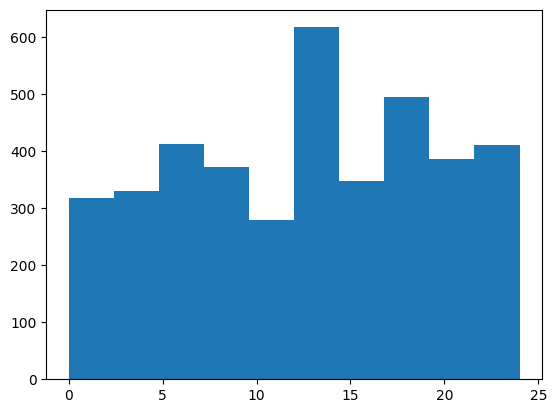

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y_train_raw)

# Load resnet50 trained on imagenet from keras

In [16]:
from keras.applications.resnet50 import ResNet50

resnet_model = ResNet50(weights="imagenet")
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Change resnet input and output layers, build new model

In [17]:
from keras.models import Model, Sequential
from keras.layers import Dense

last_layer = resnet_model.get_layer("avg_pool")
resnet_layers_up_to_last = Model(inputs=resnet_model.inputs, outputs=last_layer.output)

tuned_resnet = Sequential()
tuned_resnet.add(resnet_layers_up_to_last)
tuned_resnet.add(Dense(25, activation="sigmoid"))

# We let the last 3 blocks train
for layer in tuned_resnet.layers[0].layers[-11:]:
    layer.trainable = True
    
tuned_resnet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
tuned_resnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_4 (Functional)       │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
from keras.utils import to_categorical

y_train = to_categorical(y_train_raw)
y_test = to_categorical(y_test_raw)

tuned_resnet.fit(
    x_train, 
    y_train, 
    epochs=15, 
    validation_data=(x_test, y_test)
)

Epoch 1/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 429s 3s/step - accuracy: 0.3299 - loss: 2.5061 - val_accuracy: 0.1765 - val_loss: 7.7194
Epoch 2/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.7135 - loss: 0.9641 - val_accuracy: 0.2980 - val_loss: 2.9647
Epoch 3/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 482s 4s/step - accuracy: 0.8422 - loss: 0.5088 - val_accuracy: 0.4888 - val_loss: 2.1330
Epoch 4/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.9166 - loss: 0.2789 - val_accuracy: 0.2673 - val_loss: 4.1469
Epoch 5/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.9163 - loss: 0.2527 - val_accuracy: 0.5755 - val_loss: 1.7697
Epoch 6/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.9425 - loss: 0.1824 - val_accuracy: 0.4449 - val_loss: 2.7390
Epoch 7/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.9648 - loss: 0.1192 - val_accuracy: 0.4531 - val_loss: 3.0177
Epoch 8/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9636 - loss: 0.1297 - val_accu

# Save resnet50 feature extractor to .onnx

In [20]:
import numpy as np
import tensorflow as tf
import tf2onnx
import onnx
import onnxruntime as rt

input_signature = [tf.TensorSpec([1, 224, 224, 3], tf.double, name='x')]
tuned_resnet.output_names=['output']

onnx_model, _ = tf2onnx.convert.from_keras(tuned_resnet, input_signature, opset=13)
onnx.save(onnx_model, "finetuned_resnet50_groceries_224_224_3.onnx")

session = rt.InferenceSession("finetuned_resnet50_groceries_224_224_3.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name

test_sample = x_test[0]
test_sample_bulk = np.array([test_sample.astype(np.float64)])
onx_features = session.run(None, {input_name: test_sample_bulk})[0][0]
rs50_features = tuned_resnet.predict(test_sample_bulk)[0]

print("onx shape:", onx_features.shape)
print("rs50 shape:", rs50_features.shape)
print("length onx, rs50 diff:", len(onx_features) - len(rs50_features))
print("max onx, rs50 diff:", max(onx_features - rs50_features))
print("min onx, rs50 diff:", min(onx_features - rs50_features))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
onx shape: (25,)
rs50 shape: (25,)
length onx, rs50 diff: 0
max onx, rs50 diff: 2.682209e-07
min onx, rs50 diff: -1.8626451e-07
